### Section 0: Data Preprocessing

> Add blockquote



In [1]:
import tensorflow as tf

# List physical devices
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print("Num GPUs Available: ", len(gpus))
else:
    print("No GPUs found.")

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


Import Libraries

In [ ]:
# Core imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Sklearn metrics
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Plotting
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams

# Text preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re
import string
from collections import Counter

# PyTorch & Torchtext
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence

# Optional: suppress warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load Data

In [ ]:
import pandas as pd

# Construct the full path to the CSV file
csv_path = f"{path}/training.1600000.processed.noemoticon.csv"

# Load the dataset
data = pd.read_csv(csv_path, encoding="ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]

Data Overview

In [ ]:
print(data.head())
print(data.tail())
print(data.columns)
print('lenght of data is', len(data))
print(data.shape)
print(data.info())
print(data.dtypes)

   label        time                          date     query       username  \
0      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4      0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew   
         label        time                          date     query  \
1599994      4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599995      4  2193601969  Tue Jun 16 08:40:49 PDT 200

In [ ]:
# Check missing data
np.sum(data.isnull().any(axis=1))

np.int64(0)

In [ ]:
print('Count of columns in the data is:  ', len(data.columns))
print('Count of rows in the data is:  ', len(data))

Count of columns in the data is:   6
Count of rows in the data is:   1599999


In [ ]:
# Check whether there is neutral sentiment with numerical label '2'
if (data['label'] == 2).any():
    print("There are values equal to 2 in the 'label' column.")
else:
    print("There are no values equal to 2 in the 'label' column.")

There are no values equal to 2 in the 'label' column.


Data Cleaning and Preparation

In [ ]:
# Select the 'text' and 'label' columns
data=data[['text','label']]
# Modify 'label' column, turn label to binary form (Positive Sentiment = 1, Negative Sentiment = 0)
data['label'][data['label']==4] = 1
# Separating positive and negative tweets
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [ ]:
# Limit the number of both positive and negative tweets dataset to 20,000
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]
data = pd.concat([data_pos, data_neg])

In [ ]:
# Combine positive and negative tweets as training dataset
data = pd.concat([data_pos, data_neg])
access_point1 = data

### Section 1: Baseline model


Model-Specific Preprocessing

In [ ]:
# Make text in lower case
data['text']=data['text'].str.lower()
data['text'].tail()

,text
19995,one more day of holidays
19996,feeling so down right now .. i hate you damn h...
19997,"geez,i hv to read the whole book of personalit..."
19998,i threw my sign at donnie and he bent over to ...
19999,@heather2711 good thing i didn't find any then...


In [ ]:
# Stopwords list provided by NLTK (common English words that are often filtered out)
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"a, about, above, after, again, against, ain, all, am, an, and, any, are, aren, aren't, as, at, be, because, been, before, being, below, between, both, but, by, can, couldn, couldn't, d, did, didn, didn't, do, does, doesn, doesn't, doing, don, don't, down, during, each, few, for, from, further, had, hadn, hadn't, has, hasn, hasn't, have, haven, haven't, having, he, he'd, he'll, her, here, hers, herself, he's, him, himself, his, how, i, i'd, if, i'll, i'm, in, into, is, isn, isn't, it, it'd, it'll, it's, its, itself, i've, just, ll, m, ma, me, mightn, mightn't, more, most, mustn, mustn't, my, myself, needn, needn't, no, nor, not, now, o, of, off, on, once, only, or, other, our, ours, ourselves, out, over, own, re, s, same, shan, shan't, she, she'd, she'll, she's, should, shouldn, shouldn't, should've, so, some, such, t, than, that, that'll, the, their, theirs, them, themselves, then, there, these, they, they'd, they'll, they're, they've, this, those, through, to, too, under, until, up, 

In [ ]:
# Remove the stopwords
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))

In [ ]:
# Remove the punctuations
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))

In [ ]:
# Remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))

# Remove email
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
data['text']= data['text'].apply(lambda x: cleaning_email(x))

# Remove URL's
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))

# Remove numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))

Tokenization

In [ ]:
# Create a tokenizer that divide text into word sequences, ignoring spaces, punctuation, and other non-word elements
tokenizer = RegexpTokenizer(r'\w+')
# Process each tweet to produce a list of word tokens
data['text'] = data['text'].apply(tokenizer.tokenize)

In [ ]:
# Apply Stemming: Reduce words to their base form by removing inflectional endings
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [ ]:
# Apply Lemmatization: Reduce words to their dictionary form to achieve more accurate root form
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Separate feature and label
X = data.text
y = data.label

In [ ]:
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
# Parameters
max_len = 500
vocab_size = 2000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Tokenization
tokenizer = get_tokenizer('basic_english')

# 2. Build vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        if isinstance(text, (list, tuple)):
            text = ' '.join(text)
        yield tokenizer(text)

# Build vocab - X should be your list of text samples
vocab = build_vocab_from_iterator(yield_tokens(X),
                                 max_tokens=vocab_size,
                                 specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

# 3. Convert texts to sequences of integers with automatic GPU handling
def text_to_sequence(text):
    if isinstance(text, (list, tuple)):
        text = ' '.join(text)
    return torch.tensor(vocab(tokenizer(text)),
                      dtype=torch.long,
                      device=device)

# Create sequences on GPU
sequences = [text_to_sequence(text) for text in X]

# 4. Pad/truncate sequences on GPU
pad_idx = vocab['<pad>']
sequences_matrix = pad_sequence(sequences,
                              batch_first=True,
                              padding_value=pad_idx)

# Ensure all sequences are exactly max_len
if sequences_matrix.size(1) < max_len:
    pad_tensor = torch.full((sequences_matrix.size(0),
                           max_len - sequences_matrix.size(1)),
                           pad_idx,
                           device=device)
    sequences_matrix = torch.cat([sequences_matrix, pad_tensor], dim=1)
elif sequences_matrix.size(1) > max_len:
    sequences_matrix = sequences_matrix[:, :max_len]

# Convert to float16 for GPU operations
sequences_matrix = sequences_matrix.to(torch.float16)

# Now you can use sequences_matrix in your model
# Make sure your model is also on the same device


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [ ]:
import random

# Ensure sequences_matrix and y are torch tensors
if not isinstance(y, torch.Tensor):
    y = torch.tensor(y, dtype=torch.long)

# Make sure they're on the same device
y = y.to(device)
sequences_matrix = sequences_matrix.to(device)

# Shuffle indices
num_samples = sequences_matrix.size(0)
indices = list(range(num_samples))
random.seed(2)
random.shuffle(indices)

# Define split sizes
split = int(0.7 * num_samples)  # 70% train, 30% test
train_indices = indices[:split]
test_indices = indices[split:]

# Split the tensors
X_train_tensor = sequences_matrix[train_indices]
X_test_tensor = sequences_matrix[test_indices]
Y_train_tensor = y[train_indices]
Y_test_tensor = y[test_indices]


In [ ]:
# Check the shape of processed dataset
sequences_matrix.shape

torch.Size([40000, 500])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from tqdm import tqdm

class PyTorchLSTMModel(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=300, hidden_dim=64,
                 fc_dim=256, max_len=500):
        super(PyTorchLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, seq_length)
        x = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM layer
        lstm_out, _ = self.lstm(x)  # (batch_size, seq_length, hidden_dim)
        # Get the last time step's output
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_dim)

        # Fully connected layers
        x = torch.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

# Initialize model
model = PyTorchLSTMModel()

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters())

# Training function
def train_model(model, train_loader, val_loader, epochs=20, batch_size=2000, learning_rate=0.001):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase with progress bar
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_train += (predicted.squeeze() == labels).sum().item()
            total_train += labels.size(0)

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}: '
              f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}')

    # Convert to numpy arrays
    history = {k: np.array(v) for k, v in history.items()}

    print('Training finished!')
    print(f'Final train accuracy: {history["train_acc"][-1]:.4f}')
    print(f'Final validation accuracy: {history["val_acc"][-1]:.4f}')

    return history

# Evaluation function
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted.squeeze() == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(data_loader), correct / total

# Usage example:
# train_loader = DataLoader(train_dataset, batch_size=2000, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=2000)
# history = train_model(model, train_loader, val_loader)

Train Model

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

# Force CPU usage
device = torch.device('cpu')
model = model.to(device)  # Make sure model is on CPU

# 1. Predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Convert X_test to Long tensor on CPU
    X_test_tensor = torch.tensor(X_test_tensor, dtype=torch.long).to(device)

    # Get predictions
    y_pred_prob = model(X_test_tensor).squeeze().numpy()  # Already on CPU
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary prediction

# 2. ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_tensor, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# 4. Precision, recall rates plot
precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# 5. Classification Report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=['Class 0', 'Class 1']))

NameError: name 'X_test' is not defined

In [ ]:
plt.plot(np.arange(20),train_acc,label = 'Training accuracy')
plt.plot(np.arange(20),val_acc,label = 'Validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training and validation accuracy versus epochs")
plt.legend()
plt.show()

plt.plot(np.arange(20),train_loss,label = 'Training losses')
plt.plot(np.arange(20),val_loss,label = 'Validation losses')
plt.title("Training and validation losses versus epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

### Section 2: Different combinations of tokenization approaches and Bi-LSTM


Bi-gram + Bi-LSTM

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import bigrams
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
nltk.download('punkt_tab')

In [ ]:
data = access_point1
data['text']=data['text'].str.lower()
data['text'].tail()

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))

def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)
data['text']= data['text'].apply(lambda x: cleaning_email(x))

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))


X=data.text
y=data.label

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import bigrams

# 确保数据包已下载
try:
    word_tokenize("test")
except LookupError:
    nltk.download('punkt')

def create_bigrams(texts):
    bigram_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())  # 现在不会报错
        bi_tokens = bigrams(tokens)
        bigram_texts.append(' '.join(['_'.join(token) for token in bi_tokens]))
    return bigram_texts

# 使用示例
X_bigrams = create_bigrams(data['text'])

# 继续您的处理流程
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X_bigrams)
sequences = tok.texts_to_sequences(X_bigrams)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)
sequences_matrix.shape


(40000, 500)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)
from tensorflow.keras.layers import Bidirectional

def tensorflow_based_model():
    inputs = Input(name='inputs', shape=[max_len])  # Step 1
    layer = Embedding(2000, 300, input_length=max_len)(inputs)  # Step 2
    layer = Bidirectional(LSTM(64))(layer)  # Step 3, changed to BiLSTM
    layer = Dense(256, name='FC1')(layer)  # Step 4
    layer = Activation('relu')(layer)  # Step 5
    layer = Dropout(0.5)(layer)  # Step 6
    layer = Dense(1, name='out_layer')(layer)  # Step 4 again but this time it's giving only one output as we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer)  # Step 5 but this time the activation function is sigmoid for only one output.
    model = Model(inputs=inputs, outputs=layer)  # Here we are getting the final output value in the model for classification
    return model  # Function returning the value when we call it

model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=1000,
    epochs=20,
    validation_split=0.1
)

# Convert history to numpy arrays
train_loss = np.array(history.history['loss'])
train_acc = np.array(history.history['accuracy'])
val_loss = np.array(history.history['val_loss'])
val_acc = np.array(history.history['val_accuracy'])

print('Training finished!')
print(f'Final train accuracy: {train_acc[-1]:.4f}')
print(f'Final validation accuracy: {val_acc[-1]:.4f}')

Epoch 1/20
26/26 [==============================] - 7s 167ms/step - loss: 0.6080 - accuracy: 0.6638 - val_loss: 0.5281 - val_accuracy: 0.7404
Epoch 2/20
26/26 [==============================] - 4s 148ms/step - loss: 0.5010 - accuracy: 0.7636 - val_loss: 0.5489 - val_accuracy: 0.7350
Epoch 3/20
26/26 [==============================] - 4s 147ms/step - loss: 0.4751 - accuracy: 0.7778 - val_loss: 0.5101 - val_accuracy: 0.7464
Epoch 4/20
26/26 [==============================] - 4s 153ms/step - loss: 0.4576 - accuracy: 0.7890 - val_loss: 0.5061 - val_accuracy: 0.7496
Epoch 5/20
26/26 [==============================] - 4s 145ms/step - loss: 0.4436 - accuracy: 0.7977 - val_loss: 0.5175 - val_accuracy: 0.7543
Epoch 6/20
26/26 [==============================] - 4s 150ms/step - loss: 0.4279 - accuracy: 0.8053 - val_loss: 0.5116 - val_accuracy: 0.7521
Epoch 7/20
26/26 [==============================] - 4s 147ms/step - loss: 0.4105 - accuracy: 0.8155 - val_loss: 0.5456 - val_accuracy: 0.7554
Epoch 

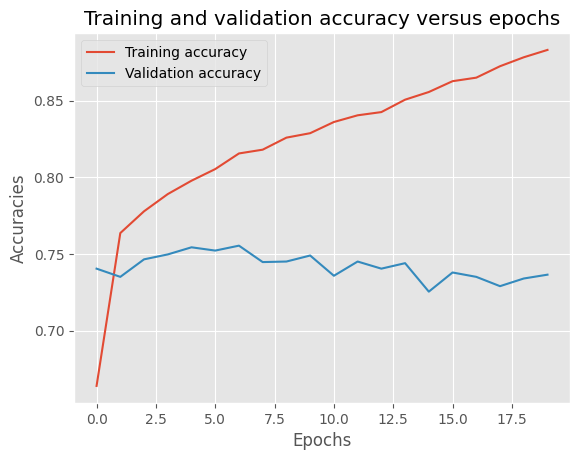

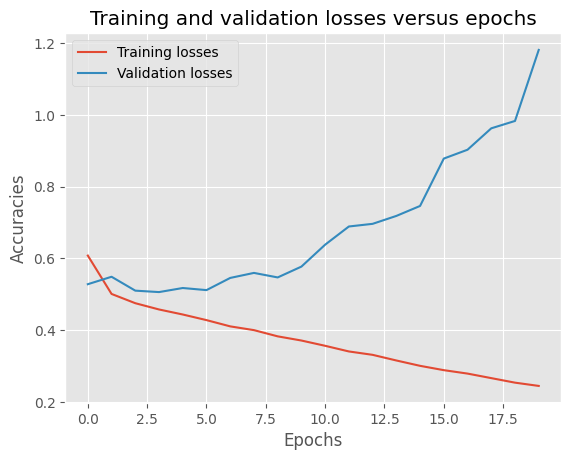

In [ ]:
plt.plot(np.arange(20),train_acc,label = 'Training accuracy')
plt.plot(np.arange(20),val_acc,label = 'Validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training and validation accuracy versus epochs")
plt.legend()
plt.show()

plt.plot(np.arange(20),train_loss,label = 'Training losses')
plt.plot(np.arange(20),val_loss,label = 'Validation losses')
plt.title("Training and validation losses versus epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

375/375 [==============================] - 12s 30ms/step


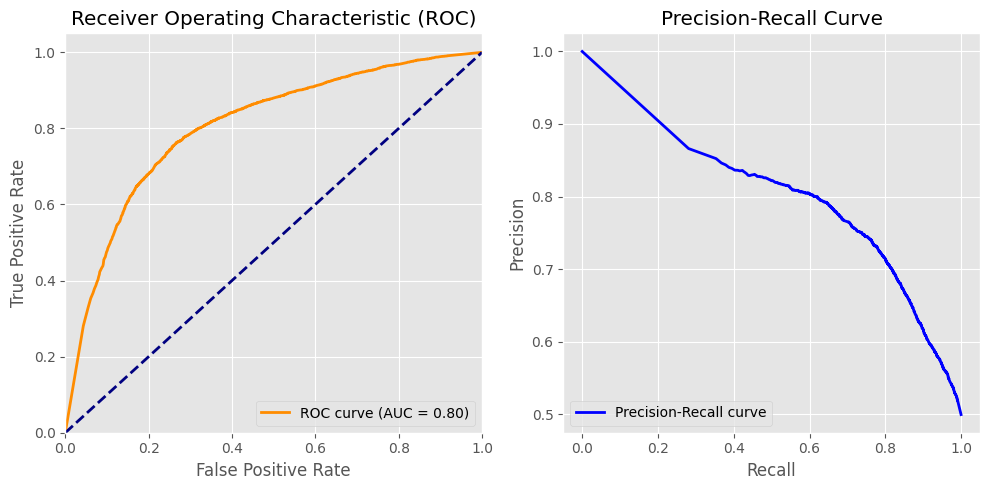


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.77      0.75      6009
     Class 1       0.76      0.72      0.74      5991

    accuracy                           0.74     12000
   macro avg       0.74      0.74      0.74     12000
weighted avg       0.74      0.74      0.74     12000



In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report

# 1. predicions
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# 2.ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# 4. Precision, recall rates plot
precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

#
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=['Class 0', 'Class 1']))

Tri-gram + Bi-LSTM

In [ ]:
from nltk.util import trigrams  # Import the trigrams function

def create_trigrams(texts):
    trigram_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())  # Tokenizing the cleaned text
        tri_tokens = trigrams(tokens)
        trigram_texts.append(' '.join(['_'.join(token) for token in tri_tokens]))
    return trigram_texts

In [ ]:
# Apply trigram creation on the cleaned texts
X_trigrams = create_trigrams(data['text'].tolist())

# Tokenization and Padding
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X_trigrams)
sequences = tok.texts_to_sequences(X_trigrams)
sequences_matrix = pad_sequences(sequences, maxlen=max_len)
sequences_matrix.shape


(40000, 500)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)
from tensorflow.keras.layers import Bidirectional

def tensorflow_based_model():
    inputs = Input(name='inputs', shape=[max_len])  # Step 1
    layer = Embedding(2000, 300, input_length=max_len)(inputs)  # Step 2
    layer = Bidirectional(LSTM(64))(layer)  # Step 3, changed to BiLSTM
    layer = Dense(256, name='FC1')(layer)  # Step 4
    layer = Activation('relu')(layer)  # Step 5
    layer = Dropout(0.5)(layer)  # Step 6
    layer = Dense(1, name='out_layer')(layer)  # Step 4 again but this time it's giving only one output as we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer)  # Step 5 but this time the activation function is sigmoid for only one output.
    model = Model(inputs=inputs, outputs=layer)  # Here we are getting the final output value in the model for classification
    return model  # Function returning the value when we call it

model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=1000,
    epochs=20,
    validation_split=0.1
)

# Convert history to numpy arrays
train_loss = np.array(history.history['loss'])
train_acc = np.array(history.history['accuracy'])
val_loss = np.array(history.history['val_loss'])
val_acc = np.array(history.history['val_accuracy'])

print('Training finished!')
print(f'Final train accuracy: {train_acc[-1]:.4f}')
print(f'Final validation accuracy: {val_acc[-1]:.4f}')

Epoch 1/20
26/26 [==============================] - 7s 168ms/step - loss: 0.6174 - accuracy: 0.6522 - val_loss: 0.5573 - val_accuracy: 0.7139
Epoch 2/20
26/26 [==============================] - 4s 152ms/step - loss: 0.5172 - accuracy: 0.7519 - val_loss: 0.5330 - val_accuracy: 0.7404
Epoch 3/20
26/26 [==============================] - 4s 148ms/step - loss: 0.4903 - accuracy: 0.7700 - val_loss: 0.5582 - val_accuracy: 0.7321
Epoch 4/20
26/26 [==============================] - 4s 149ms/step - loss: 0.4734 - accuracy: 0.7810 - val_loss: 0.5153 - val_accuracy: 0.7511
Epoch 5/20
26/26 [==============================] - 4s 149ms/step - loss: 0.4609 - accuracy: 0.7907 - val_loss: 0.5228 - val_accuracy: 0.7436
Epoch 6/20
26/26 [==============================] - 4s 148ms/step - loss: 0.4423 - accuracy: 0.8008 - val_loss: 0.5265 - val_accuracy: 0.7489
Epoch 7/20
26/26 [==============================] - 4s 152ms/step - loss: 0.4255 - accuracy: 0.8100 - val_loss: 0.5524 - val_accuracy: 0.7332
Epoch 

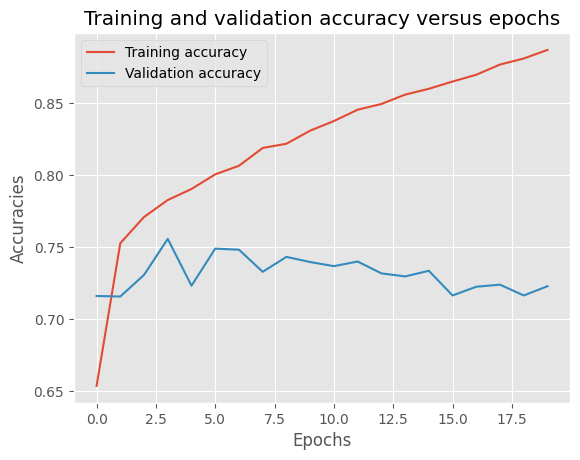

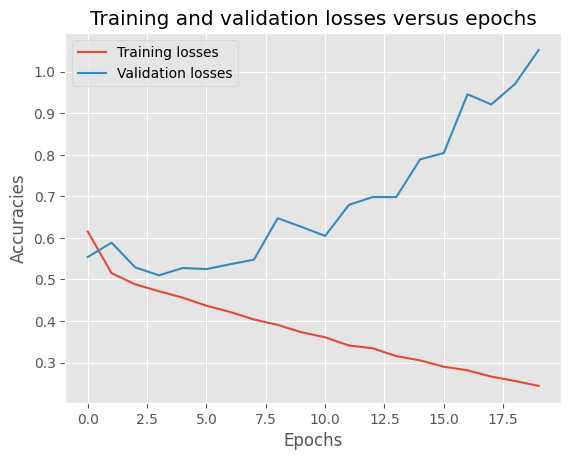

In [ ]:
plt.plot(np.arange(20),train_acc,label = 'Training accuracy')
plt.plot(np.arange(20),val_acc,label = 'Validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training and validation accuracy versus epochs")
plt.legend()
plt.show()

plt.plot(np.arange(20),train_loss,label = 'Training losses')
plt.plot(np.arange(20),val_loss,label = 'Validation losses')
plt.title("Training and validation losses versus epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

375/375 [==============================] - 12s 30ms/step


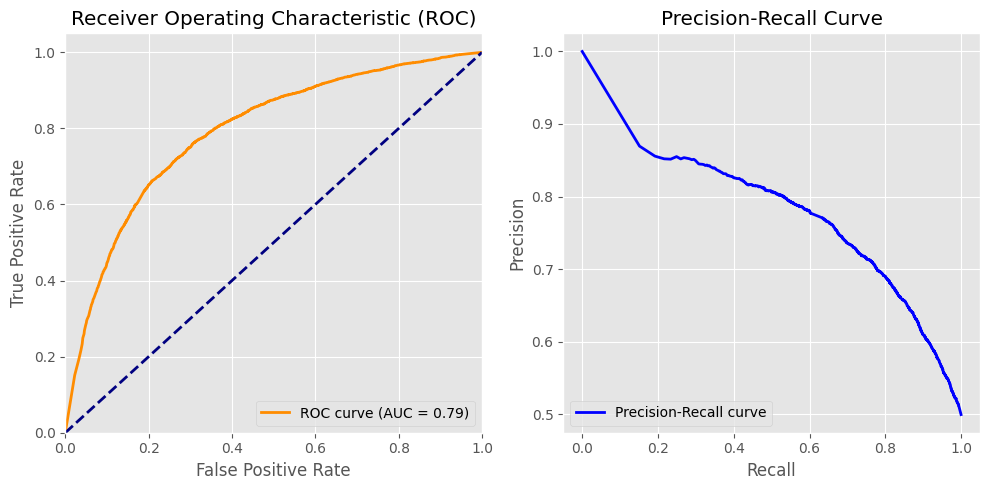


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.76      0.73      6009
     Class 1       0.74      0.69      0.72      5991

    accuracy                           0.73     12000
   macro avg       0.73      0.73      0.72     12000
weighted avg       0.73      0.73      0.72     12000



In [ ]:
# 1. predicions
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# 2.ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# 4. Precision, recall rates plot
precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

#
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=['Class 0', 'Class 1']))

Word2Vec + Bi-LSTM

In [ ]:
from gensim.models import KeyedVectors
import numpy as np
import gensim.downloader as api

word_vectors = api.load("word2vec-google-news-300")

embedding_matrix = np.zeros((2000, 300))  # 2000 is vocab size, 300 is the dimension of Word2Vec vectors

for bigram, i in tok.word_index.items():
    if i < 2000:  # Only consider the top 2000 words in the vocabulary
        try:
            embedding_vector = word_vectors[bigram]  # Get the embedding vector for the word
            embedding_matrix[i] = embedding_vector  # Assign it to the embedding matrix
        except KeyError:
            # Words not found in the embedding index will be all zeros.
            pass

In [ ]:
def tensorflow_based_model():
    inputs = Input(name='inputs', shape=[max_len])
    # Replace the original Embedding layer with the pre-trained Word2Vec embeddings
    layer = Embedding(2000, 300, input_length=max_len, weights=[embedding_matrix], trainable=True)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model


model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=1000,
    epochs=20,
    validation_split=0.1
)

# Convert history to numpy arrays
train_loss = np.array(history.history['loss'])
train_acc = np.array(history.history['accuracy'])
val_loss = np.array(history.history['val_loss'])
val_acc = np.array(history.history['val_accuracy'])
print('Training finished !!')

Epoch 1/20
26/26 [==============================] - 5s 106ms/step - loss: 0.6267 - accuracy: 0.6487 - val_loss: 0.5705 - val_accuracy: 0.7114
Epoch 2/20
26/26 [==============================] - 2s 94ms/step - loss: 0.5366 - accuracy: 0.7374 - val_loss: 0.5264 - val_accuracy: 0.7354
Epoch 3/20
26/26 [==============================] - 2s 95ms/step - loss: 0.5059 - accuracy: 0.7573 - val_loss: 0.5928 - val_accuracy: 0.7214
Epoch 4/20
26/26 [==============================] - 2s 86ms/step - loss: 0.4876 - accuracy: 0.7714 - val_loss: 0.5080 - val_accuracy: 0.7482
Epoch 5/20
26/26 [==============================] - 2s 89ms/step - loss: 0.4699 - accuracy: 0.7779 - val_loss: 0.5100 - val_accuracy: 0.7507
Epoch 6/20
26/26 [==============================] - 2s 86ms/step - loss: 0.4530 - accuracy: 0.7852 - val_loss: 0.5155 - val_accuracy: 0.7486
Epoch 7/20
26/26 [==============================] - 2s 87ms/step - loss: 0.4386 - accuracy: 0.7915 - val_loss: 0.5535 - val_accuracy: 0.7254
Epoch 8/20
2

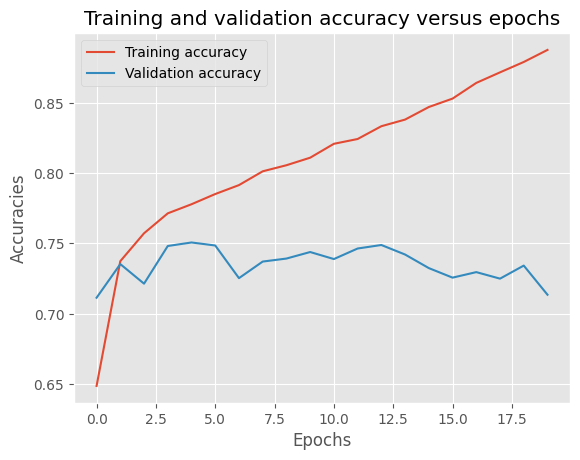

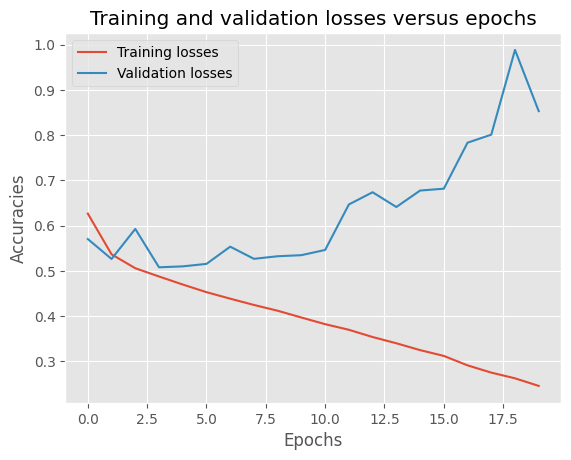

In [ ]:
plt.plot(np.arange(20),train_acc,label = 'Training accuracy')
plt.plot(np.arange(20),val_acc,label = 'Validation accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Training and validation accuracy versus epochs")
plt.legend()
plt.show()

plt.plot(np.arange(20),train_loss,label = 'Training losses')
plt.plot(np.arange(20),val_loss,label = 'Validation losses')
plt.title("Training and validation losses versus epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

375/375 [==============================] - 7s 16ms/step


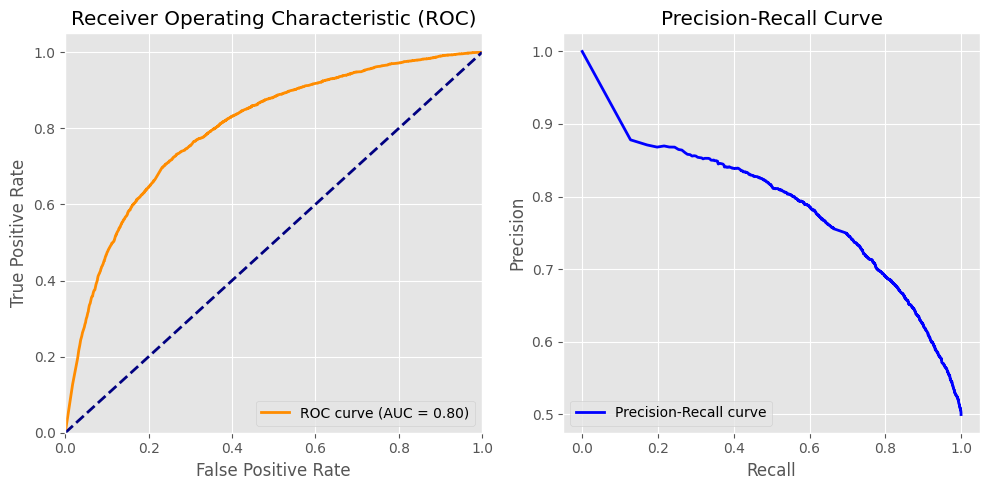


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.72      0.73      6009
     Class 1       0.73      0.74      0.73      5991

    accuracy                           0.73     12000
   macro avg       0.73      0.73      0.73     12000
weighted avg       0.73      0.73      0.73     12000



In [ ]:
# 1. predicions
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# 2.ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# 4. Precision, recall rates plot
precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

#
print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=['Class 0', 'Class 1']))

### Section 3: More advanced structures: BERT and RoBERTa

#### Method 1: BERT model

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import kagglehub

# Download dataset
path = kagglehub.dataset_download("kazanova/sentiment140")
csv_path = f"{path}/training.1600000.processed.noemoticon.csv"
data = pd.read_csv(csv_path, encoding="ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]
data = data[['text', 'label']]
data['label'] = data['label'].replace({4: 1, 0: 0})

# Limit dataset for speed
pos = data[data['label'] == 1].iloc[:20000]
neg = data[data['label'] == 0].iloc[:20000]
data = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)

# Train/val/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(texts, labels):
    encodings = tokenizer(list(texts), padding=True, truncation=True,
                          max_length=128, return_tensors="pt")
    encodings['labels'] = torch.tensor(list(labels.values), dtype=torch.long)
    return encodings

train_data = tokenize(train_texts, train_labels)
val_data = tokenize(val_texts, val_labels)
test_data = tokenize(test_texts, test_labels)

class SentimentDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

train_loader = DataLoader(SentimentDataset(train_data), batch_size=32, shuffle=True)
val_loader = DataLoader(SentimentDataset(val_data), batch_size=32)
test_loader = DataLoader(SentimentDataset(test_data), batch_size=32)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)

# Training loop
epochs = 4
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    print(f"Epoch {epoch+1} Train Loss: {total_train_loss / len(train_loader):.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {key: val.to(device) for key, val in batch.items()}
            outputs = model(**inputs)
            total_val_loss += outputs.loss.item()
    print(f"Epoch {epoch+1} Val Loss: {total_val_loss / len(val_loader):.4f}")

# Testing
model.eval()
correct = total = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        inputs = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == inputs['labels']).sum().item()
        total += len(preds)

print(f"Test Accuracy: {correct / total:.4f}")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/4 - Training: 100%|██████████| 800/800 [02:07<00:00,  6.27it/s]


Epoch 1 Train Loss: 0.4424


Validation: 100%|██████████| 200/200 [00:08<00:00, 23.60it/s]


Epoch 1 Val Loss: 0.3941


Epoch 2/4 - Training: 100%|██████████| 800/800 [02:22<00:00,  5.61it/s]


Epoch 2 Train Loss: 0.3106


Validation: 100%|██████████| 200/200 [00:09<00:00, 22.10it/s]


Epoch 2 Val Loss: 0.4010


Epoch 3/4 - Training: 100%|██████████| 800/800 [02:25<00:00,  5.50it/s]


Epoch 3 Train Loss: 0.1877


Validation: 100%|██████████| 200/200 [00:09<00:00, 22.09it/s]


Epoch 3 Val Loss: 0.5101


Epoch 4/4 - Training: 100%|██████████| 800/800 [02:27<00:00,  5.43it/s]


Epoch 4 Train Loss: 0.1000


Validation: 100%|██████████| 200/200 [00:08<00:00, 22.24it/s]


Epoch 4 Val Loss: 0.6062


Testing: 100%|██████████| 250/250 [00:11<00:00, 21.94it/s]

Test Accuracy: 0.8205


#### Method 2: RoBERTa model

c:\Users\Kevin.LAPTOP-8AK6LATV\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/4 - Training: 100%|██████████| 307/307 [01:57<00:00,  2.61it/s]


Epoch 1 Train Loss: 0.4280, Train Acc: 0.8010


Validation: 100%|██████████| 132/132 [00:17<00:00,  7.52it/s]


Epoch 1 Val Loss: 0.3303, Val Acc: 0.8607


Epoch 2/4 - Training: 100%|██████████| 307/307 [02:10<00:00,  2.36it/s]


Epoch 2 Train Loss: 0.2954, Train Acc: 0.8793


Validation: 100%|██████████| 132/132 [00:21<00:00,  6.16it/s]


Epoch 2 Val Loss: 0.3253, Val Acc: 0.8675


Epoch 3/4 - Training: 100%|██████████| 307/307 [02:26<00:00,  2.10it/s]


Epoch 3 Train Loss: 0.2164, Train Acc: 0.9148


Validation: 100%|██████████| 132/132 [00:23<00:00,  5.60it/s]


Epoch 3 Val Loss: 0.3688, Val Acc: 0.8683


Epoch 4/4 - Training: 100%|██████████| 307/307 [02:29<00:00,  2.05it/s]


Epoch 4 Train Loss: 0.1550, Train Acc: 0.9408


Validation: 100%|██████████| 132/132 [00:22<00:00,  5.87it/s]


Epoch 4 Val Loss: 0.3970, Val Acc: 0.8663


Testing: 100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Test Accuracy: 0.8707
Precision: 0.8761
Recall:    0.8639
F1 Score:  0.8700

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87      5991
    Positive       0.88      0.86      0.87      6009

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000

AUC: 0.9393


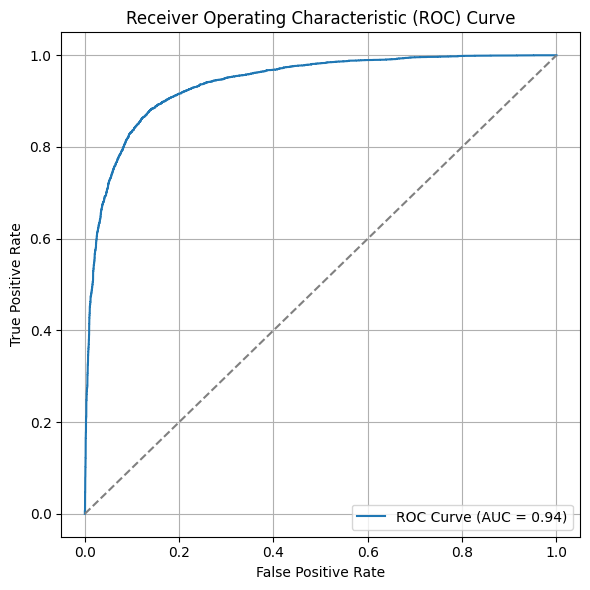

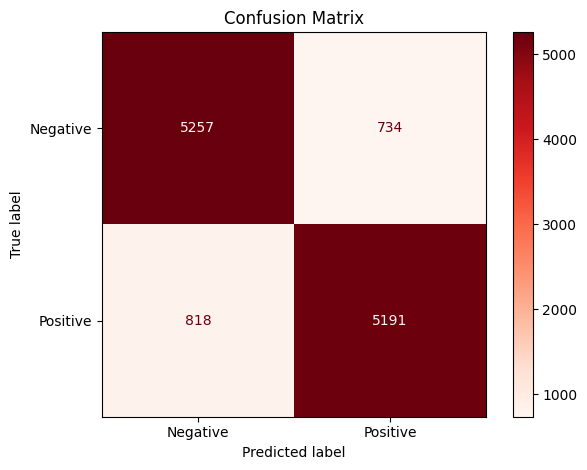

In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, precision_score, f1_score,
    classification_report
)


from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import kagglehub

# Download dataset
path = kagglehub.dataset_download("kazanova/sentiment140")
csv_path = f"{path}/training.1600000.processed.noemoticon.csv"
data = pd.read_csv(csv_path, encoding="ISO-8859-1", engine="python")
data.columns = ["label", "time", "date", "query", "username", "text"]
data = data[['text', 'label']]
data['label'] = data['label'].replace({4: 1, 0: 0})

# Reduce to 40k samples for speed
pos = data[data['label'] == 1].iloc[:20000]
neg = data[data['label'] == 0].iloc[:20000]
data = pd.concat([pos, neg]).sample(frac=1).reset_index(drop=True)

# Train/val/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['label'], test_size=0.3, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.3, random_state=42)

# Tokenization
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

history = {
    "train_loss": [],
    "val_loss": [],
    "train_accuracy": [],
    "val_accuracy": []
}

def tokenize(texts, labels):
    encodings = tokenizer(list(texts), padding=True, truncation=True,
                         max_length=64, return_tensors="pt")
    encodings['labels'] = torch.tensor(list(labels.values), dtype=torch.long)
    return encodings

train_data = tokenize(train_texts, train_labels)
val_data = tokenize(val_texts, val_labels)
test_data = tokenize(test_texts, test_labels)

class SentimentDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __len__(self):
        return len(self.encodings['input_ids'])
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

train_loader = DataLoader(SentimentDataset(train_data), batch_size=64, shuffle=True)
val_loader = DataLoader(SentimentDataset(val_data), batch_size=64)
test_loader = DataLoader(SentimentDataset(test_data), batch_size=64)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)

# Training loop
num_epochs = 4
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_train_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        correct_train += (preds == batch['labels']).sum().item()
        total_train += batch['labels'].size(0)

    train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    print(f"Epoch {epoch+1} Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct_val += (preds == batch['labels']).sum().item()
            total_val += batch['labels'].size(0)

    val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    print(f"Epoch {epoch+1} Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save to history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(val_acc)


# Evaluation
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # prob of positive class
        all_labels.extend(batch['labels'].cpu().numpy())

# Accuracy
accuracy = sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Precision, Recall, F1
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Full Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

# ROC Curve + AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

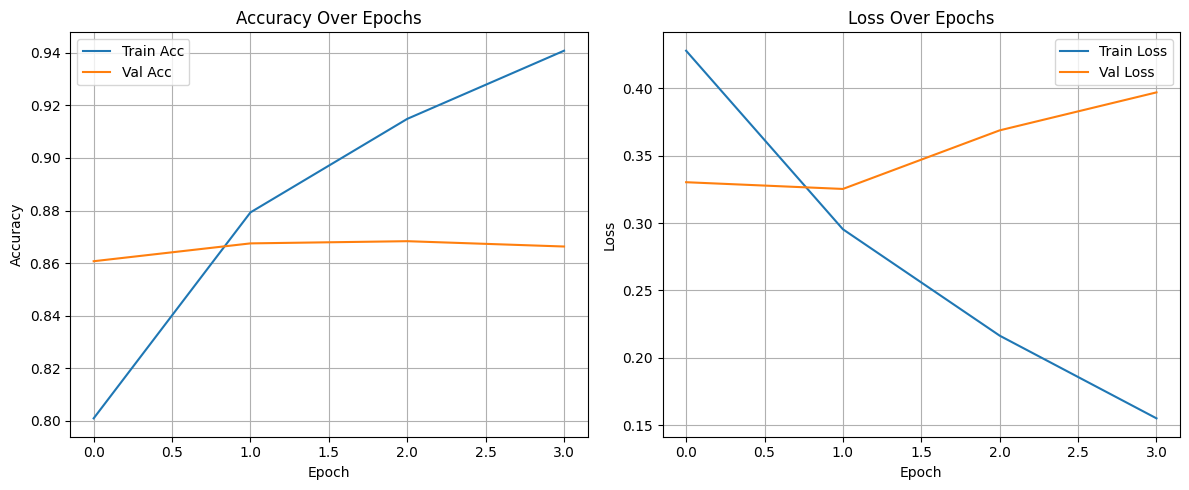

In [2]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Section 4: Result Analysis